<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/ASSIGNMENT_3_GIACOMO_CARFI_RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 3**

Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1.     Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2.     Use the trained RBM to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3.     Reconstruct the original test images from their hidden encoding and confront the reconstructions with the original image (use a suitable quantitative metric to assess the reconstraction quality and also choose few examples to confront visually).

Boltzmann Machine is a generative unsupervised model, which involves learning a probability distribution from an original dataset and using it to make inferences about never before seen data.

# Downloading the dataset

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. The images are 28x28 pixels.

In [2]:
X, Y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# print some information about the dataset
print(X.shape)

(70000, 784)


In [4]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

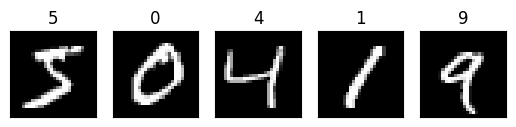

In [5]:
plot_example(X, Y)

Prepare data for the task

In [6]:
# normalize data
X /= 255

# binarize data
X = np.where(X > 0.5, 1, 0)

# train - test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=10000, random_state=42, stratify=Y)
X_train.shape

(60000, 784)

In [7]:
np.unique(Y_train, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([5917, 6752, 5991, 6121, 5849, 5411, 5894, 6251, 5850, 5964]))

In [8]:
np.unique(Y_test, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([ 986, 1125,  999, 1020,  975,  902,  982, 1042,  975,  994]))

# Implementation of a Restricted Boltzmann Machine

In [9]:
from sklearn.utils import gen_batches

class RBM():

  def __init__(self, visible_dim, hidden_dim):
    self.visible_dim = visible_dim
    self.hidden_dim = hidden_dim
    # weights
    self.W = np.random.randn(visible_dim, hidden_dim)
    # biases
    self.bh = np.random.randn(hidden_dim)
    self.bv = np.random.randn(visible_dim)
    
  
  def fit(self, X, epochs=10, batch_dim=16, lr=0.01):
    '''
    Trains the restricted boltzmann machine
    '''
    for epoch in range(epochs):
      # saving the image of the weights
      self.plot_weights(step=epoch, save=True)

      error_epoch = 0
      batches = list(gen_batches(X.shape[0], batch_dim))
      
      for batch in batches:
        batch = X[batch.start:batch.stop]
        batch_size = batch.shape[0]

        # Wake - prob of h given v
        ones_poshidP = np.ones((batch_size, self.hidden_dim))
        poshidP = ones_poshidP/(ones_poshidP + np.exp(-np.dot(batch,self.W) - self.bh))
        wake = np.dot(batch.T, poshidP)

        # Dream - prob of v giben h
        ones_reconDataP = np.ones((batch_size, self.visible_dim))
        reconDataP = ones_reconDataP / (ones_reconDataP + np.exp(-np.dot(poshidP, np.transpose(self.W))-self.bv))
        ones_neghidP = np.ones((batch_size, self.hidden_dim))
        neghidP = ones_neghidP / (ones_neghidP + np.exp(-np.dot(reconDataP, self.W) - self.bh))
        dream = np.dot(np.transpose(reconDataP), neghidP)

        # Error
        error = np.sum((batch-reconDataP)**2)/batch_size

        # Update Contrastive Divergence-1
        self.W += lr*(wake-dream)/batch_size
        self.bh += lr*(np.sum(poshidP-neghidP, axis=0))/batch_size
        self.bv += lr*(np.sum(batch-reconDataP, axis=0))/batch_size

        error_epoch += error

      error_epoch /= len(batches)
      print(f"epoch: {epoch}/{epochs} \t{'error:'} {error_epoch}")


  def reconstruct(self, X):
    '''
    Reconstruct the data from the hidden encoding
    '''
    ones_poshidP = np.ones((X.shape[0], self.hidden_dim))
    poshidP = ones_poshidP/(ones_poshidP + np.exp(-np.dot(X,self.W)-self.bh))
    poshidS = poshidP > np.random.uniform(size=poshidP.shape)
    
    ones_reconDataP = np.ones((X.shape[0], self.visible_dim))
    reconDataP = ones_reconDataP / (ones_reconDataP + np.exp(-np.dot(poshidS,np.transpose(self.W))-self.bv))

    return reconDataP

  def plot_weights(self, title='weights', step=0, save=True):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''

    cols = 5
    rows = int(self.hidden_dim / cols)


    plt.clf()
    fig, axes = plt.subplots(rows, cols, figsize=(10,10))
    fig.suptitle(f"{title} step:{step}")
    for i in range(rows):
        for j in range(cols):
            axes[i, j].imshow(self.W[:,i*cols+j].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')

    plt.subplots_adjust(wspace=1, hspace=1)
    
    if save:
      plt.savefig(f"{title}_step_{step}.png")
    else:
      plt.show()

    plt.close()

# Training of the RBM

In [10]:
# turn off the interactive mode of matplotlib in order to avoid to show multiple plots
plt.ioff()
rbm = RBM(visible_dim=X_train.shape[1], hidden_dim=30)
rbm.fit(X_train, epochs=20, batch_dim=128, lr=0.7)
plt.ion()

epoch: 0/20 	error: 55.049146547752265
epoch: 1/20 	error: 45.36431632737899
epoch: 2/20 	error: 43.16381624001753
epoch: 3/20 	error: 42.45525822112822
epoch: 4/20 	error: 41.87152234355793
epoch: 5/20 	error: 41.43356734989419
epoch: 6/20 	error: 41.15663955993966
epoch: 7/20 	error: 40.95790975625046
epoch: 8/20 	error: 40.78047354271091
epoch: 9/20 	error: 40.59930735675496
epoch: 10/20 	error: 40.39270767053479
epoch: 11/20 	error: 40.11599234551879
epoch: 12/20 	error: 39.86016066420576
epoch: 13/20 	error: 39.665658012971
epoch: 14/20 	error: 39.553959226704045
epoch: 15/20 	error: 39.44426426229313
epoch: 16/20 	error: 39.318194068409554
epoch: 17/20 	error: 39.170550470352616
epoch: 18/20 	error: 39.077338856567415
epoch: 19/20 	error: 38.987018193979154


In [11]:
# show the weights over epochs
import glob
from PIL import Image
import re 
import math
from pathlib import Path 

file_pattern = re.compile(r'.*?(\d+).*?')
def get_order(file):
    match = file_pattern.match(Path(file).name)
    if not match:
        return math.inf
    return int(match.groups()[0])


frames = [Image.open(image) for image in sorted(glob.glob(f"./weights_step_*.png"), key=get_order)]
frame_one = frames[0]
frame_one.save("weights.gif", format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=0)
    


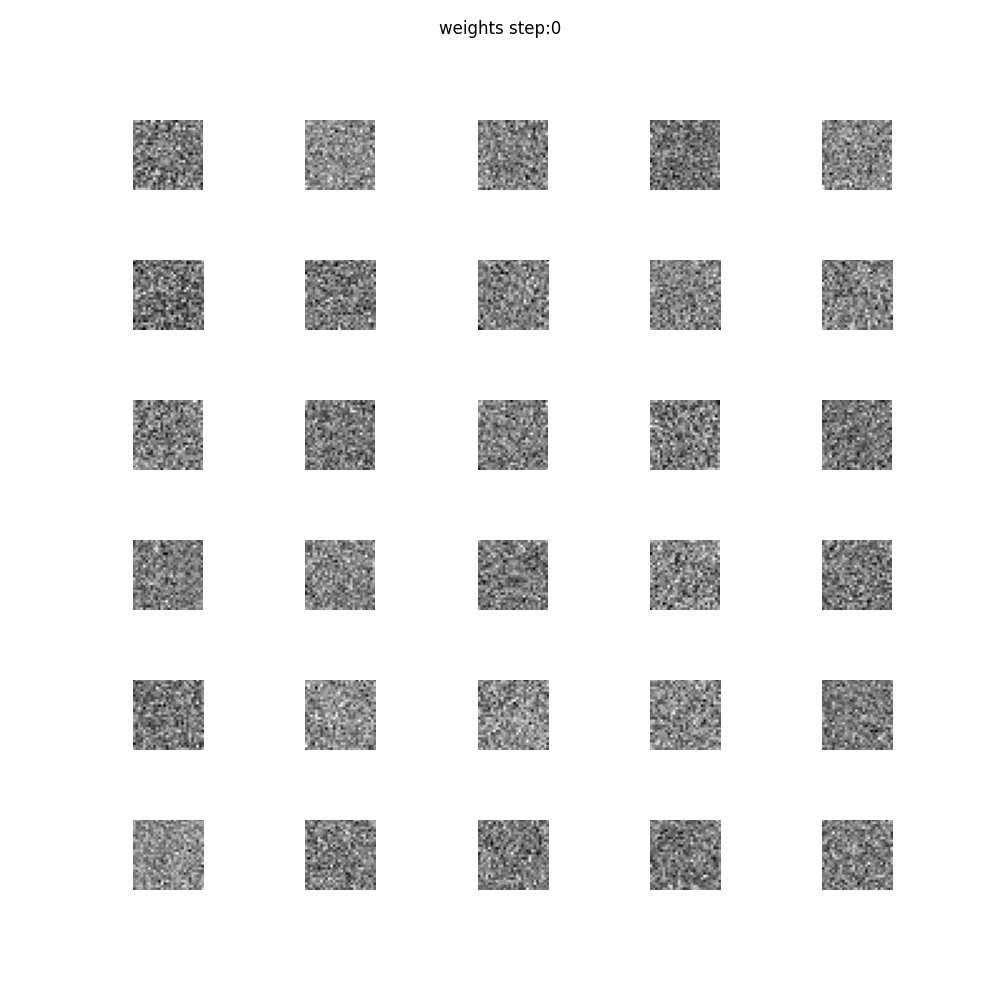

In [12]:
from IPython.display import Image
Image(open('weights.gif','rb').read())

# Encode one image per digit

In [21]:
# get one image of the test set for each digit
# Create a list of indices for each digit
digit_indices = [np.where(Y_test == str(i))[0][0] for i in range(10)]
digit_indices

[25, 3, 10, 18, 1, 2, 20, 0, 4, 12]

In [23]:
resticted_set = X_test[digit_indices]
resticted_set.shape

(10, 784)

In [24]:
reconstructed = rbm.reconstruct(resticted_set)

Text(0, 0.5, 'REC.')

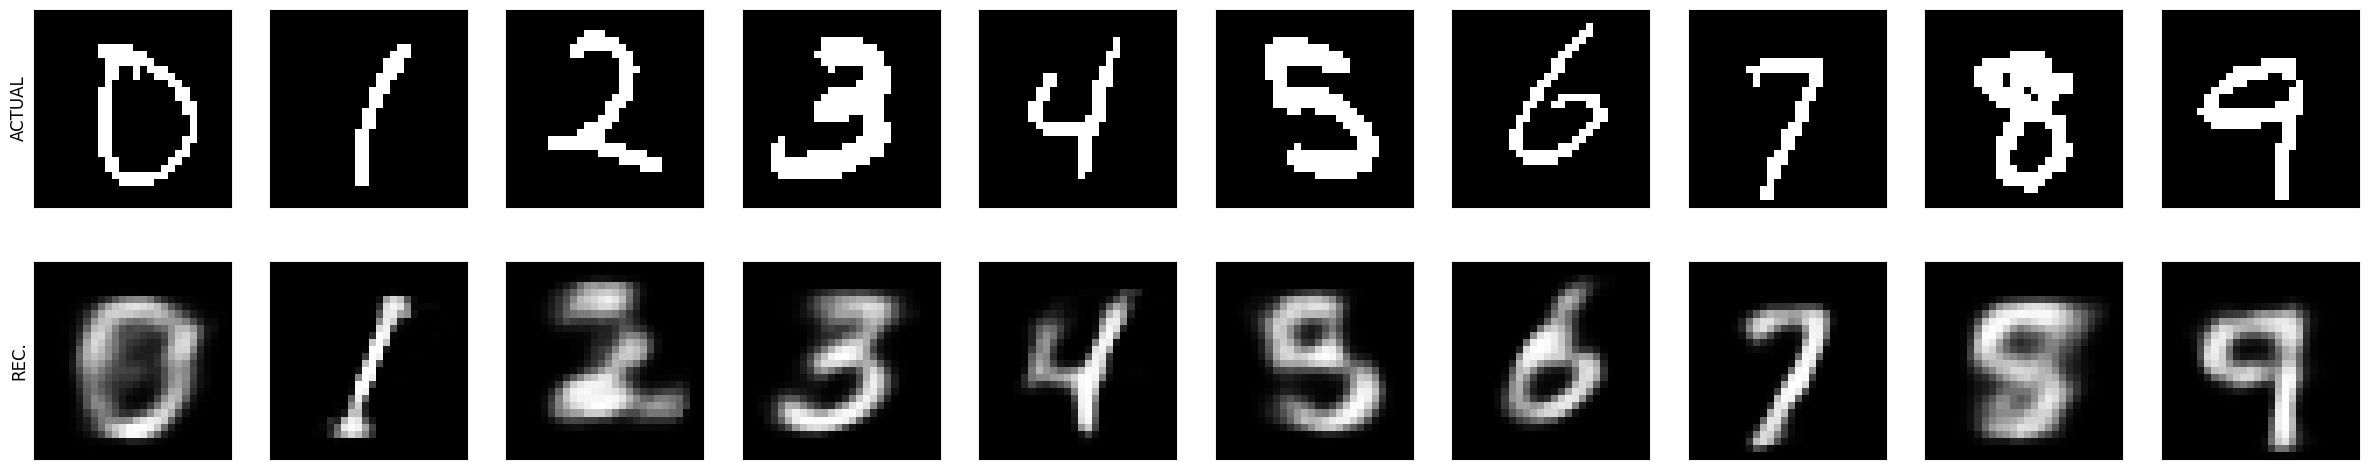

In [31]:
# show five sample images
rows = 2
columns = 10

fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 6))
for i in range(rows):
    for j in range(columns):
        if i==0:
          axes[i, j].imshow(resticted_set[j].reshape(28, 28), cmap='gray') 
        else:
          axes[i, j].imshow(reconstructed[j].reshape(28, 28), cmap='gray')

        axes[i, j].tick_params(left = False, right = False , labelleft = False,
                labelbottom = False, bottom = False)
         
axes[0, 0].set_ylabel("ACTUAL", fontsize=12)        
axes[1, 0].set_ylabel("REC.", fontsize=12)

# Reconstruction Accuracy 

To measure the similarity between the original image and the reconstructed one the metric used is the SSIM. SSIM index provides a quantitative measure of how similar two images are, taking into account both their content and structure.



In [38]:
from skimage.metrics import structural_similarity as ssim
# reconstruct the whole testset
reconstructed = rbm.reconstruct(X_test)

# convert test set into float numbers to apply ssim score
X_test1 = X_test.astype(float)

ssim_score=0
for i in range(len(X_test1)):
  ssim_score +=ssim(X_test1[i], reconstructed[i])

# mean overall the samples
ssim_score /= len(X_test)

print(f"SSIM score: {ssim_score}")


SSIM score: 0.7030726365978901


# Personal Note

In this notebook, a Restricted Boltzmann Machine was implemented and trained to perform image encoding of the mnist dataset. The score for the recontructed images is 0.70 according to the SSIM score.  
Different combinations of learning rate, minibatch, number of neurons, epochs were tried to test the RBM but a better result could be obtained by performing model selection on these parameters. Using momentum in updating the weights could also provide better results.
Plotting the weights is also useful and it helps to understand the features to which each neuron responds, what the weights capture is more or less the shape of the numbers